In [28]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
customers = pd.read_csv("/content/Customers.csv")
transactions = pd.read_csv("/content/Transactions.csv")


In [29]:
# Summarize transaction data for each customer
customer_transactions = transactions.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'TotalValue': 'sum'
}).reset_index()

# Merge customer data with transaction summary
customer_profiles = customers.merge(customer_transactions, on='CustomerID', how='left').fillna(0)

# Encode categorical variables
customer_profiles = pd.get_dummies(customer_profiles, columns=['Region'], drop_first=True)

# Drop non-numeric columns for clustering
data_for_clustering = customer_profiles.drop(columns=['CustomerID', 'CustomerName', 'SignupDate'])

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_clustering)


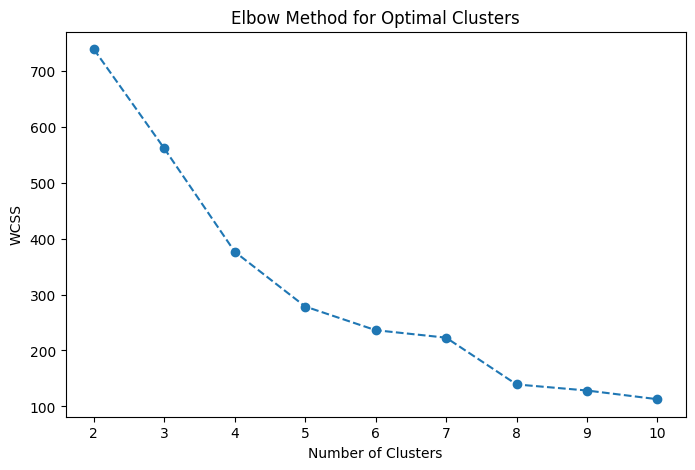

In [30]:
# Determine the optimal number of clusters using the Elbow Method
wcss = []  # Within-cluster sum of squares
for k in range(2, 11):  # Test cluster numbers between 2 and 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), wcss, marker='o', linestyle='--')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()


In [31]:
# Choose the optimal number of clusters based on the Elbow Method
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(data_scaled)

# Add cluster labels to the original dataset
customer_profiles['Cluster'] = cluster_labels

# Calculate evaluation metrics
silhouette = silhouette_score(data_scaled, cluster_labels)
db_index = davies_bouldin_score(data_scaled, cluster_labels)
wcss_final = kmeans.inertia_

print(f"Silhouette Score: {silhouette:.3f}")
print(f"Davies-Bouldin Index: {db_index:.3f}")
print(f"Final WCSS: {wcss_final:.3f}")


Silhouette Score: 0.431
Davies-Bouldin Index: 0.976
Final WCSS: 376.586


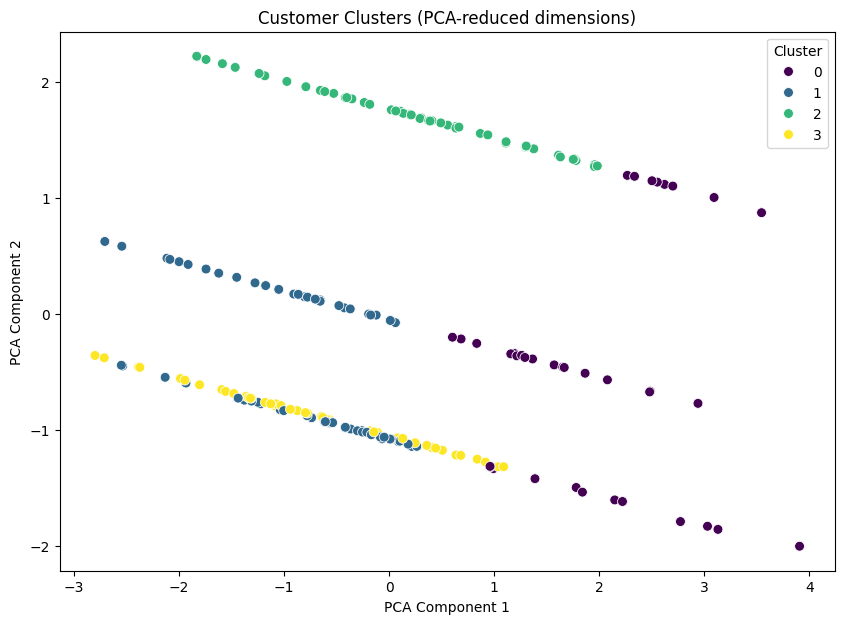

In [32]:
# Visualize clusters (using PCA for dimensionality reduction)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=cluster_labels, palette="viridis", s=50)
plt.title("Customer Clusters (PCA-reduced dimensions)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()


In [33]:
# Save cluster results
customer_profiles.to_csv("Customer_Segmentation_Results.csv", index=False)

# Save cluster summary statistics
cluster_summary = customer_profiles.select_dtypes(include=['number']).groupby('Cluster').mean()
cluster_summary['Cluster Size'] = customer_profiles['Cluster'].value_counts()
cluster_summary.to_csv("Cluster_Summary.csv", index=True)
